# 1. Libraries

In [92]:
import pandas as pd
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import util
import ast
import re
import os
import random
from scipy.stats import variation
from sklearn.metrics.pairwise import cosine_similarity
from heapq import heappush, heappop, heapify
import seaborn as sns


# 2. Helper functions

In [54]:
def cosine_similarity_adapter(x, y):
    """ 
    Calcs the cosine similarity between two vectors
    """
    return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0]

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def huff(symb2freq):
    huffmansymbols = ""
    huffw = encode(symb2freq)
    for p in huffw:
        huffmansymbols += p[1] * symb2freq[p[0]]
    huff = len(huffmansymbols) / 8
    return huff

def calculate_density(df):
    """
    Calculate the huffman coding bit size of the normalized text of the df
    """
    words = []
    for s in df['normalized_text']:
        for w in ast.literal_eval(s):
            words.append(w)
    
    symb2freq = {}
    for word in words:
        if word in symb2freq:
            symb2freq[word] += 1
        else:
            symb2freq[word] = 1

    return huff(symb2freq)

def dist_and_cv_wv(model):
    """
    Calculates the average sim and coeff of var for 10,000 random pairs of words
        Inputs: 
            - model (word2vec model): a model trained on a president corpus

        Outputs:
            - mean_dist (float): the mean cosine similarity of the 10,000 pairs
            - cv (float): the coefficient of variation of the 10,000 pairs
    """
    distances = []
    word_indexes = len(model.wv.key_to_index.keys()) - 1
    for i in range(10000): 
        rand1 = model.wv.index_to_key[random.randrange(0, word_indexes)]
        rand2 = model.wv.index_to_key[random.randrange(0, word_indexes)]
        dist = model.wv.similarity(rand1, rand2) + 1
        distances.append(dist)
        
    mean_dist = float(sum(distances)) / float(len(distances))
    cv        = variation(distances)

    return mean_dist, cv

def dist_and_cv_dv(model):
    """
    Calculates the average sim and coeff of var for 10,000 random pairs of docs
        Inputs: 
            - model (word2vec model): a model trained on a president corpus

        Outputs:
            - mean_dist (float): the mean cosine similarity of the 10,000 pairs
            - cv (float): the coefficient of variation of the 10,000 pairs
    """
    distances = []
    doc_indexes = len(model.dv.key_to_index.keys()) - 1
    for i in range(10000): 
        rand1 = model.dv.index_to_key[random.randrange(0, doc_indexes)]
        rand2 = model.dv.index_to_key[random.randrange(0, doc_indexes)]
        dist = model.dv.similarity(rand1, rand2) + 1
        distances.append(dist)
        
    mean_dist = float(sum(distances)) / float(len(distances))
    cv        = variation(distances)

    return mean_dist, cv

def assign_ideology(president):
    """
    Assigns a president an ideology
    """
    left = ['morales', 'correa', 'sanchez', 'funes', 'maduro', 'chavez']
    center_left = ['kichner', 'bachelet', 'solis', 'colom', 'ortega', 'ollanta', 'lugo', 'tabare', 'mujica']
    center_right = ['chinchilla', 'arias', 'medina', 'fernandez', 'zelaya', 'pena_nieto', 'alan']

    if president in left:
        return 'left'
    elif president in center_left:
        return 'center_left'
    elif president in center_right:
        return 'center_right'
    else:
        return 'right'
    
def assign_populist(president):
    """
    Labels presidents as populist or not
    """
    populist = ['chavez', 'maduro', 'ortega', 'correa', 'morales', 'kirchner', 'uribe']
    if president in populist:
        return 'populist'
    else:
        return 'not_populist'

# 3. Test density of language space

## 3k

In [12]:
#load csv to pd
density = pd.read_csv('../results/density.csv')

density: the average amount of conceptual information per language unit.

Denser language spaces use less language units (words, sentences, etc.) to conveys meaning.

For spaces with less topics, there should a be higher density?

In [13]:
# correr esta

#set seed and initialize dict
file_path = r"C:\Users\asarr\Documents\Projects\pol-cul-maps-latam\president_csvs\3k"
random.seed(0)
den_dict = {}

for df in os.listdir(file_path):
    #prep
    name = df.split('.')[0]
    pres_df = pd.read_csv(f'{file_path}\{df}')
    
    pres_df['tokenized_sents'] = pres_df['text2'].apply(lambda x: [util.word_tokenize_es(s) for s in util.sent_tokenize_es(x)])
    pres_df['normalized_sents'] = pres_df['tokenized_sents'].apply(lambda x: [util.normalizeTokens_es(s, lemma=False) for s in x])

    pres_df['normalized_sents'] = pres_df['normalized_sents'].apply(lambda x: [s for s in x if len(s) > 0])
    
    #huff value: communication density
    huff_val = calculate_density(pres_df)

    #avg cosine similarity: semantic density
    w2v_model = gensim.models.word2vec.Word2Vec(pres_df['normalized_sents'].sum(), sg=1, window=6)
    avg_cos_sim, cv = dist_and_cv_wv(w2v_model)

    #compile
    den_dict[name] = [huff_val, huff_val/len(pres_df), huff_val/len(pres_df['normalized_text'].sum()), avg_cos_sim, cv]

In [16]:
density = pd.DataFrame(den_dict).T
density.columns = ['huffman', 'huffman_ratio_doc', 'huffman_ratio_text', 'avg_cos_sim_wv', 'cv_wv']
density.head()

,huffman,huffman_ratio_doc,huffman_ratio_text,avg_cos_sim_wv,cv_wv
alan,165290.375,200.351970,0.131578,1.915253,0.053666
arias,31575.000,222.359155,0.131092,1.996782,0.004060
bachelet,164916.500,187.618316,0.124118,1.851611,0.075459
calderon,206975.250,223.757027,0.133629,1.892302,0.061734
cartes,94579.125,207.410362,0.124999,1.905633,0.060526


### Set ideology and populism categories

In [19]:
#set ideology and populism
density['ideology'] = density.index.map(assign_ideology)
density['populist'] = density.index.map(assign_populist)
density.head()

,huffman,huffman_ratio_doc,huffman_ratio_text,avg_cos_sim_wv,cv_wv,ideology,populist
alan,165290.375,200.351970,0.131578,1.915253,0.053666,center_right,not_populist
arias,31575.000,222.359155,0.131092,1.996782,0.004060,center_right,not_populist
bachelet,164916.500,187.618316,0.124118,1.851611,0.075459,center_left,not_populist
calderon,206975.250,223.757027,0.133629,1.892302,0.061734,right,not_populist
cartes,94579.125,207.410362,0.124999,1.905633,0.060526,right,not_populist


### Huffman ratios
Measure communication density

<Axes: title={'center': 'Huffman Ratio by President, per doc'}>

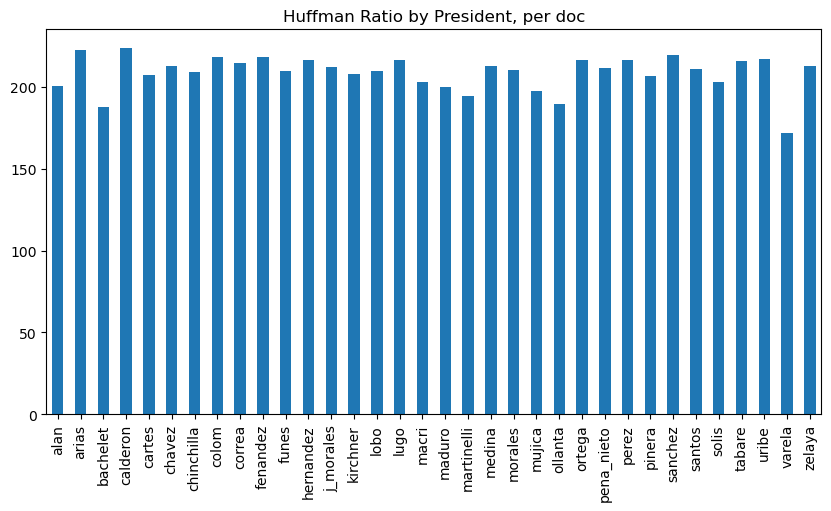

In [9]:
#graph huffman _ratio
density['huffman_ratio_doc'].plot(kind='bar', figsize=(10, 5), title='Huffman Ratio by President, per doc')

<Axes: title={'center': 'Huffman Ratio by President, full text'}>

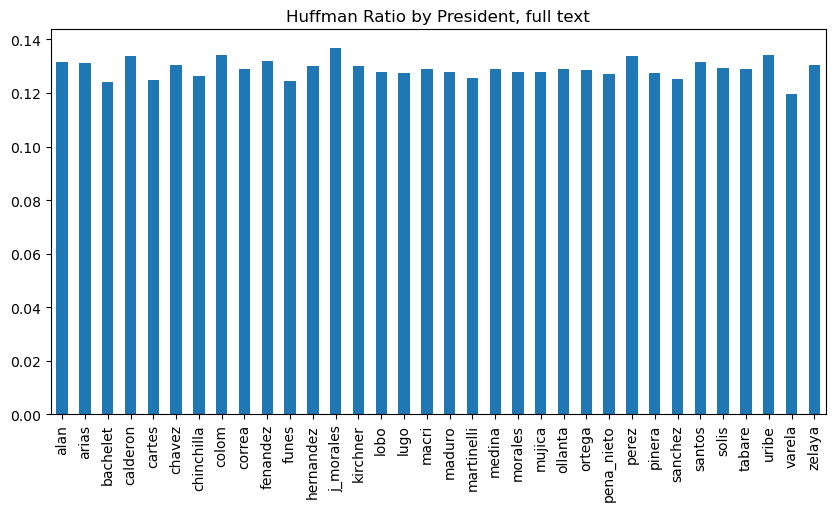

In [10]:
density['huffman_ratio_text'].plot(kind='bar', figsize=(10, 5), title='Huffman Ratio by President, full text')

### Average cosine similarity
measures semantic density

<Axes: title={'center': 'Average Cosine Similarity by President'}>

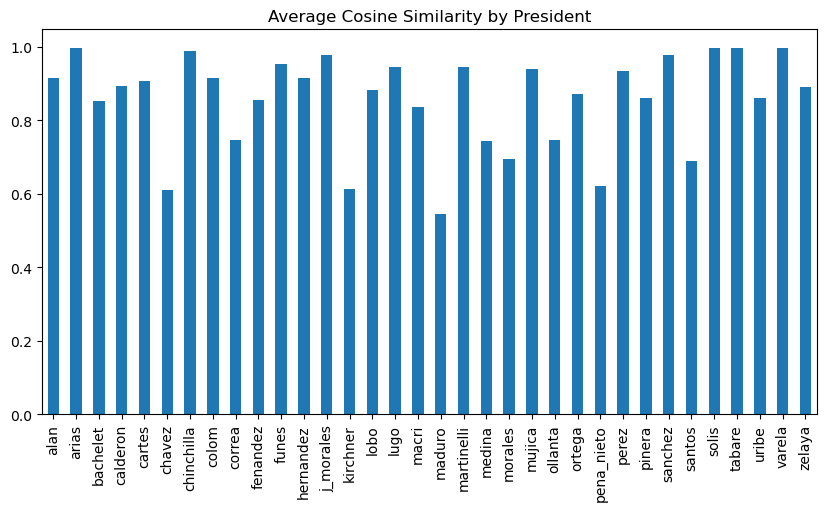

In [22]:
# graph avg_cos_sim
density['avg_cos_sim_wv'] = density['avg_cos_sim_wv'].apply(lambda x: x - 1)
density['avg_cos_sim_wv'].plot(kind='bar', figsize=(10, 5), title='Average Cosine Similarity by President')

<Axes: title={'center': 'Coefficient of Variation by President'}>

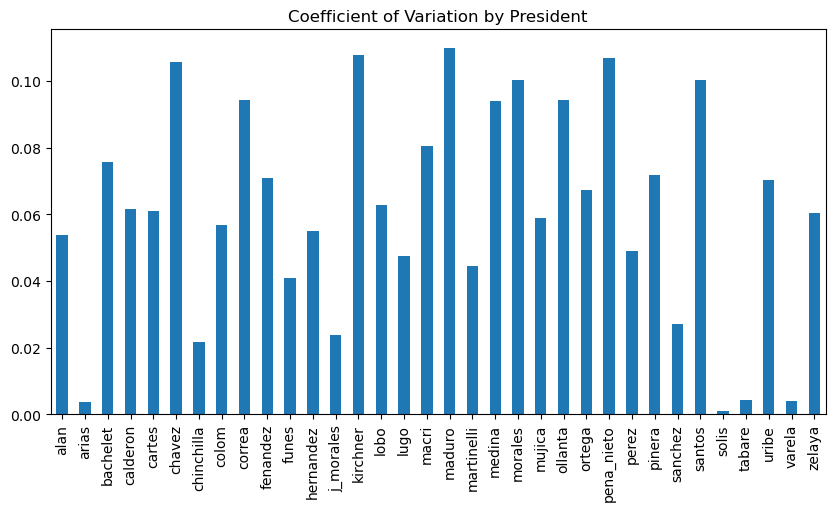

In [13]:
density['cv'].plot(kind='bar', figsize=(10, 5), title='Coefficient of Variation by President')

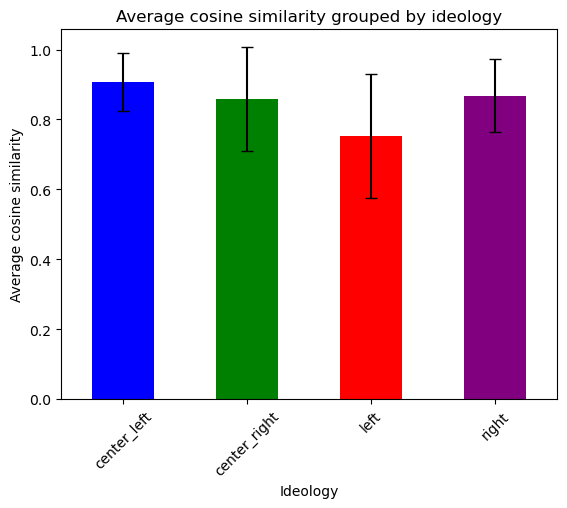

In [33]:
import matplotlib.pyplot as plt

grouped = density.groupby('ideology')['avg_cos_sim_wv'].agg(['mean', 'std'])

fig, ax = plt.subplots()
grouped['mean'].plot(kind='bar', yerr=grouped['std'], ax=ax, capsize=4, color=['blue', 'green', 'red', 'purple'])
ax.set_title('Average cosine similarity grouped by ideology')
ax.set_xlabel('Ideology')
ax.set_ylabel('Average cosine similarity')
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped.index, rotation=45)
plt.show()

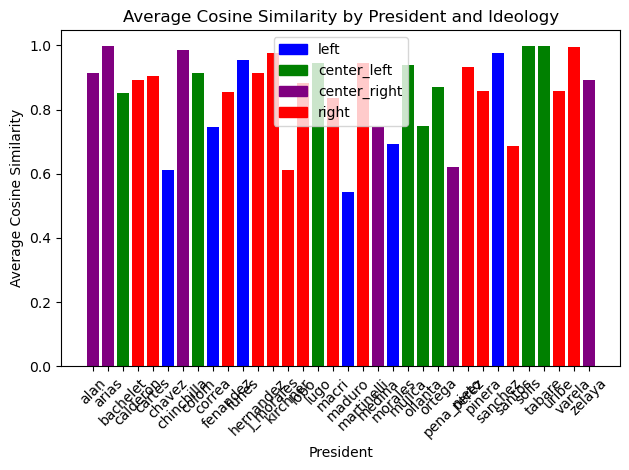

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each ideology
colors = {'left': 'blue', 'center_left': 'green', 'center_right': 'purple', 'right': 'red'}

# Plotting
fig, ax = plt.subplots()
presidents = density['president']
avg_cosine_similarity = density['avg_cos_sim_wv']
ideologies = density['ideology']

bars = ax.bar(presidents, avg_cosine_similarity, color=[colors[ideology] for ideology in ideologies])

# Adding labels and title
ax.set_xlabel('President')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity by President and Ideology')

# Adding legend based on ideology colors
legend_colors = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
ax.legend(legend_colors, colors.keys())

# Adjusting layout
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

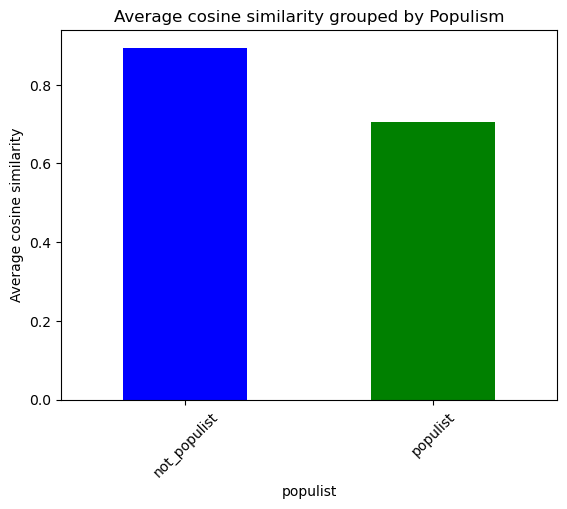

In [9]:
grouped = density.groupby('populist')['avg_cos_sim_wv'].agg(['mean', 'std'])

fig, ax = plt.subplots()
grouped['mean'].plot(kind='bar', ax=ax, capsize=4, color=['blue', 'green'])
ax.set_title('Average cosine similarity grouped by Populism')
ax.set_ylabel('Average cosine similarity')
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped.index, rotation=45)
plt.show()


In [41]:
#save df
density.to_csv(r"C:\Users\asarr\Documents\Projects\pol-cul-maps-latam\results\density.csv")

## Doc2Vec

How similar are documents inside a presidents subcorpus?

In [39]:
doc_den_dict = {}

for df in os.listdir(file_path):
    #prep
    name = df.split('.')[0]
    pres_df = pd.read_csv(f'{file_path}\{df}')

    pres_df['normalized_text'] = pres_df['normalized_text'].apply(lambda x: ast.literal_eval(x))

    #create list of lists of tagged word
    tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(pres_df['normalized_text'])]

    #train model
    model = Doc2Vec(vector_size=100, window=6, min_count=2, epochs = 40)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    #avg cosine similarity: semantic density
    avg_cos_sim, cv = dist_and_cv_dv(model)

    #compile
    doc_den_dict[name] = [avg_cos_sim, cv]


In [40]:
doc_density = pd.DataFrame(doc_den_dict).T
doc_density.columns = ['avg_cos_sim_dv', 'cv_dv']
density = density.join(doc_density)
density.head()

,huffman,huffman_ratio_doc,huffman_ratio_text,avg_cos_sim_wv,cv_wv,ideology,populist,avg_cos_sim,cv
alan,165290.375,200.351970,0.131578,0.915253,0.053666,center_right,not_populist,1.279762,0.145934
arias,31575.000,222.359155,0.131092,0.996782,0.004060,center_right,not_populist,1.783445,0.087902
bachelet,164916.500,187.618316,0.124118,0.851611,0.075459,center_left,not_populist,1.265366,0.136159
calderon,206975.250,223.757027,0.133629,0.892302,0.061734,right,not_populist,1.256573,0.145765
cartes,94579.125,207.410362,0.124999,0.905633,0.060526,right,not_populist,1.301776,0.152860


<Axes: title={'center': 'Average Cosine Similarity by President'}>

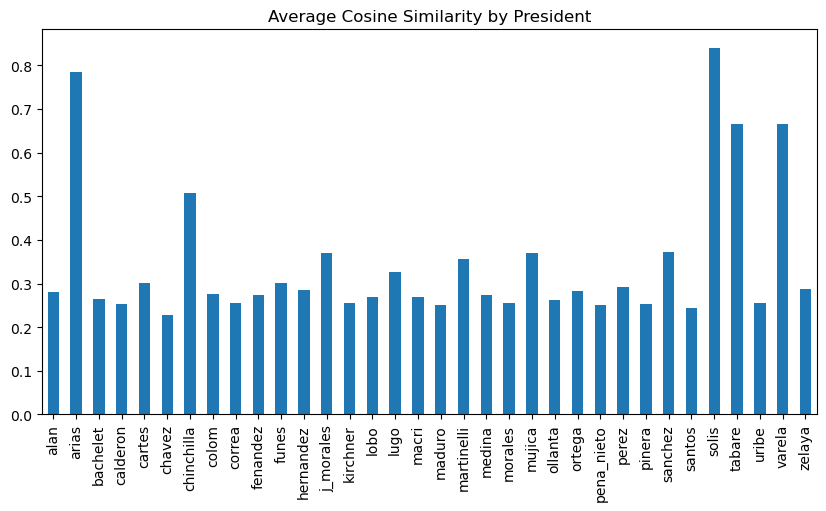

In [55]:
#graph avg_cos_sim
doc_density['avg_cos_sim'] = doc_density['avg_cos_sim'].apply(lambda x: x - 1)
doc_density['avg_cos_sim'].plot(kind='bar', figsize=(10, 5), title='Average Cosine Similarity by President')

<Axes: title={'center': 'Coefficient of Variation by President'}>

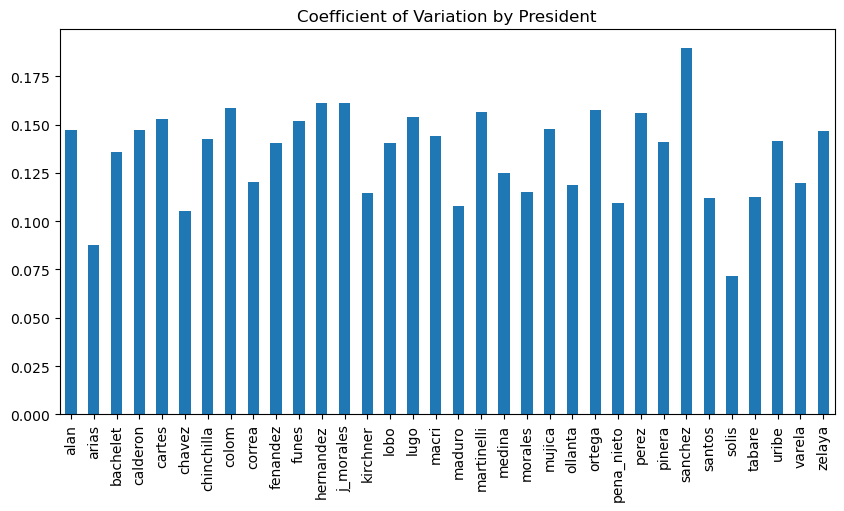

: 

In [56]:
#graph cv
doc_density['cv'].plot(kind='bar', figsize=(10, 5), title='Coefficient of Variation by President')

# 4. Average semantic similarity between documents

In [22]:
file_path = r"C:\Users\asarr\Documents\Projects\pol-cul-maps-latam\president_csvs\3k"

tagged_data = []
pres_names = []

for df in os.listdir(file_path):
    #sample docs
    name = df.split('.')[0]
    pres_names.append(name)
    pres_df = pd.read_csv(f'{file_path}\{df}')
    pres_df = pres_df.sample(50)

    pres_df['normalized_text'] = pres_df['normalized_text'].apply(lambda x: ast.literal_eval(x))

    #create list of lists of tagged word
    tagged_data += [TaggedDocument(words=doc, tags=[name + '_' + str(i)]) for i, doc in enumerate(pres_df['normalized_text'])]

#train model
model = Doc2Vec(vector_size=100, window=6, min_count=2, epochs = 40)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [152]:
cs_dict = {'President': []}

for i, vector in enumerate(model.dv.vectors):
    pres = model.dv.index_to_key[i].split('_')[0]
    cs_dict['President'].append(pres)
    row = [cosine_similarity_adapter(vector, vector2) for vector2 in model.dv.vectors]
    cs_dict[model.dv.index_to_key[i]] = row

In [153]:
df = pd.DataFrame(cs_dict)


done with calcs, now plotting
done with avg
done with var


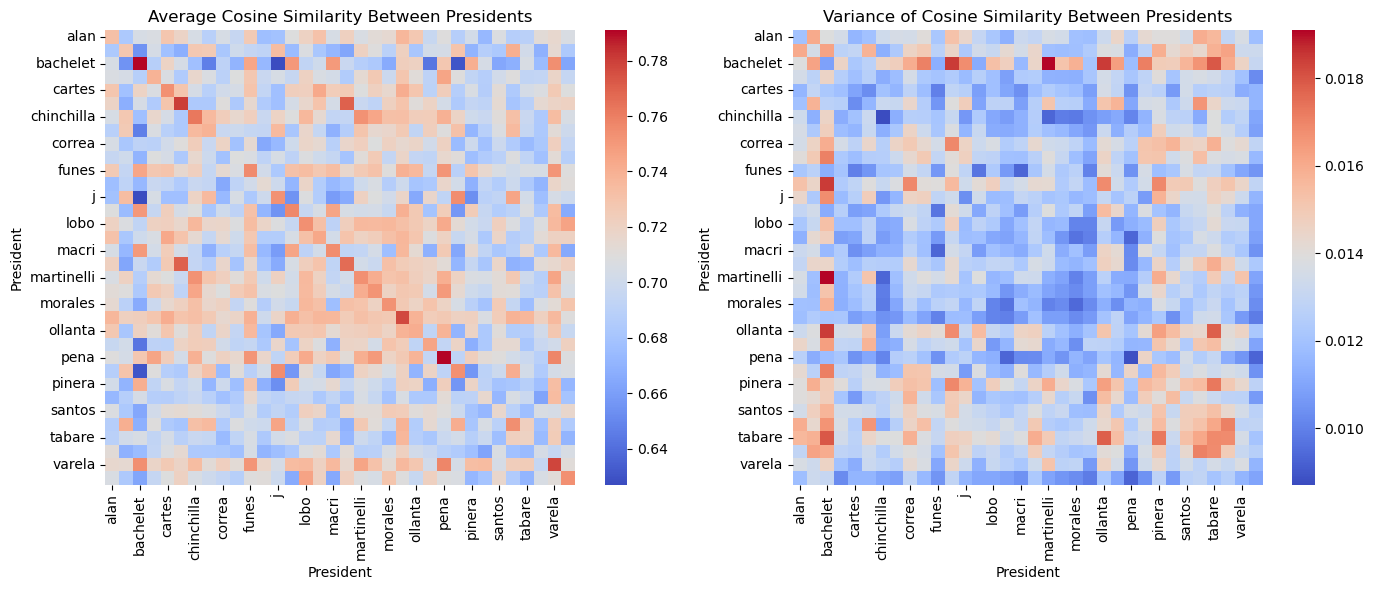

In [158]:
for column in df.columns:
    if column != 'President':
        df[column] = pd.to_numeric(df[column], errors='coerce')

# Get unique presidents
presidents = df['President'].unique()

# Initialize matrices for average and variance
avg_similarity = pd.DataFrame(np.zeros((len(presidents), len(presidents))), index=presidents, columns=presidents)
var_similarity = pd.DataFrame(np.zeros((len(presidents), len(presidents))), index=presidents, columns=presidents)

# Calculate average and variance of cosine similarities
for pres1 in presidents:
    for pres2 in presidents:
        # Get documents for each president
        docs_pres1 = df[df['President'] == pres1].drop(columns=['President']).values
        docs_pres2 = df[df['President'] == pres2].drop(columns=['President']).values
        
        # Collect similarities between all pairs of documents from pres1 and pres2
        similarities = []
        for doc1 in docs_pres1:
            for doc2 in docs_pres2:
                if not np.array_equal(doc1, doc2):
                    similarities.append(np.dot(doc1, doc2) / (np.linalg.norm(doc1) * np.linalg.norm(doc2)))
        
        # Calculate mean and variance if there are similarities
        if similarities:
            avg_similarity.loc[pres1, pres2] = np.mean(similarities)
            var_similarity.loc[pres1, pres2] = np.var(similarities)

print('done with calcs, now plotting')

# Step 2: Create Heatmaps
plt.figure(figsize=(14, 6))

# Heatmap for Average Cosine Similarity
plt.subplot(1, 2, 1)
sns.heatmap(avg_similarity, cmap='coolwarm')
plt.title('Average Cosine Similarity Between Presidents')
plt.xlabel('President')
plt.ylabel('President')

print('done with avg')

# Heatmap for Variance of Cosine Similarity
plt.subplot(1, 2, 2)
sns.heatmap(var_similarity, cmap='coolwarm')
plt.title('Variance of Cosine Similarity Between Presidents')
plt.xlabel('President')
plt.ylabel('President')

print('done with var')

plt.tight_layout()
plt.show()

# 5. Size comparisons

In [165]:
measures_dict = {'President': [], 'size': [], 'huffman_ratio': [],'avg_cos_sim': [], 'cv': []}

sizes = ['1k','3k', '5k', '10k']

for size in sizes:
    file_path = f"C:\\Users\\asarr\\Documents\\Projects\\pol-cul-maps-latam\\president_csvs\\{size}"
    print('now processing', size)
    for df in os.listdir(file_path):
        print('now processing', df)
        if size == '1k' and df == 'solis.csv':
            continue
        #prep
        name = df.split('.')[0]
        pres_df = pd.read_csv(f'{file_path}\{df}')

        pres_df['tokenized_sents'] = pres_df['text2'].apply(lambda x: [util.word_tokenize_es(s) for s in util.sent_tokenize_es(x)])
        pres_df['normalized_sents'] = pres_df['tokenized_sents'].apply(lambda x: [util.normalizeTokens_es(s, lemma=False) for s in x])

        pres_df['normalized_sents'] = pres_df['normalized_sents'].apply(lambda x: [s for s in x if len(s) > 0])
    
        #huff value: communication density
        huff_val = calculate_density(pres_df)

        #avg cosine similarity: semantic density
        w2v_model = gensim.models.word2vec.Word2Vec(pres_df['normalized_sents'].sum(), sg=1, window=6)
        avg_cos_sim, cv = dist_and_cv_wv(w2v_model)

        #compile
        measures_dict['President'].append(name)
        measures_dict['size'].append(size)
        measures_dict['huffman_ratio'].append(huff_val/len(pres_df['normalized_text'].sum()))
        measures_dict['avg_cos_sim'].append(avg_cos_sim)
        measures_dict['cv'].append(cv)

now processing 1k
now processing alan.csv
now processing arias.csv
now processing bachelet.csv
now processing calderon.csv
now processing cartes.csv
now processing chavez.csv
now processing chinchilla.csv
now processing colom.csv
now processing correa.csv
now processing fenandez.csv
now processing funes.csv
now processing hernandez.csv
now processing j_morales.csv
now processing kirchner.csv
now processing lobo.csv
now processing lugo.csv
now processing macri.csv
now processing maduro.csv
now processing martinelli.csv
now processing medina.csv
now processing morales.csv
now processing mujica.csv
now processing ollanta.csv
now processing ortega.csv
now processing pena_nieto.csv
now processing perez.csv
now processing pinera.csv
now processing sanchez.csv
now processing santos.csv
now processing solis.csv
now processing tabare.csv
now processing uribe.csv
now processing varela.csv
now processing zelaya.csv
now processing 3k
now processing alan.csv
now processing arias.csv
now processing 

In [166]:
#turn dict into df
measures = pd.DataFrame(measures_dict)

In [167]:
measures.head()

,President,size,huffman_ratio,avg_cos_sim,cv
0,alan,1k,0.116351,1.923393,0.020468
1,arias,1k,0.102034,1.180687,0.315187
2,bachelet,1k,0.108765,1.996442,0.000492
3,calderon,1k,0.114080,1.035402,0.170157
4,cartes,1k,0.101382,1.054764,0.198929


In [178]:
measures.groupby('size')['huffman_ratio'].agg(['mean', 'std'])

,mean,std
size,,
10k,0.135523,0.002514
1k,0.110273,0.008472
3k,0.128993,0.003440
5k,0.132716,0.002913


In [170]:
#save
measures.to_csv(r"C:\Users\asarr\Documents\Projects\pol-cul-maps-latam\results\measures_by_size.csv")